In [215]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Activation, Dropout
from tensorflow.keras.models import Sequential

In [216]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True )

In [217]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [218]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


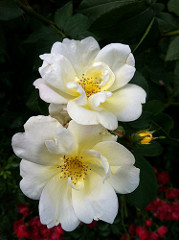

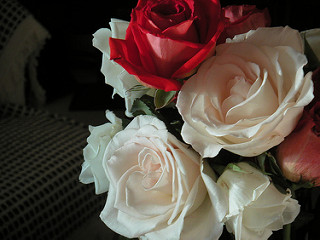

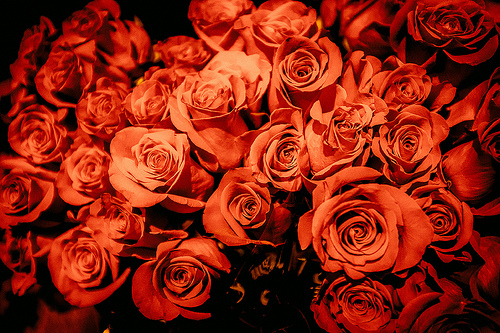

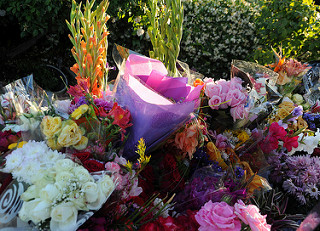

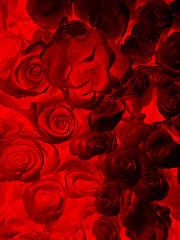

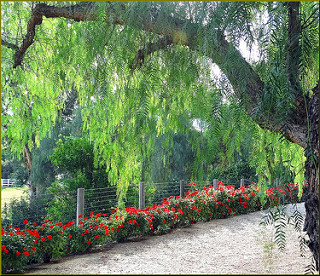

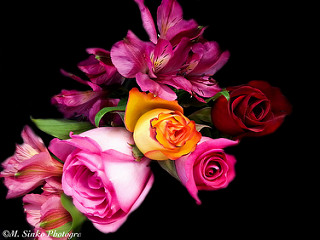

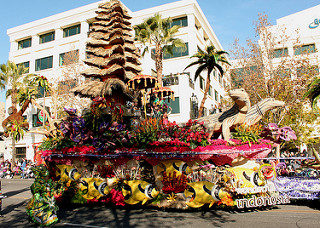

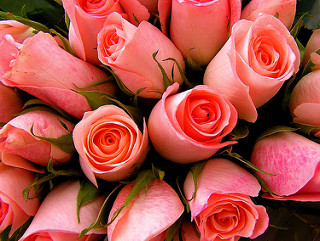

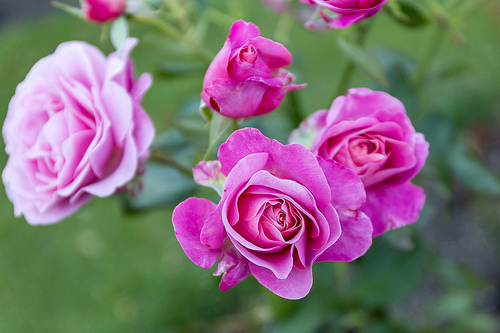

In [219]:
roses = list(data_dir.glob("roses/*"))

for i in range(10):
    im = PIL.Image.open(str(roses[i]))
    display(im)

In [220]:
batch_size = 32
img_height = 180
img_width = 180

In [221]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="training",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [222]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [223]:
# You can find the class names in the class_names attribute on these datasets

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

In [224]:
train_ds.take(11)

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

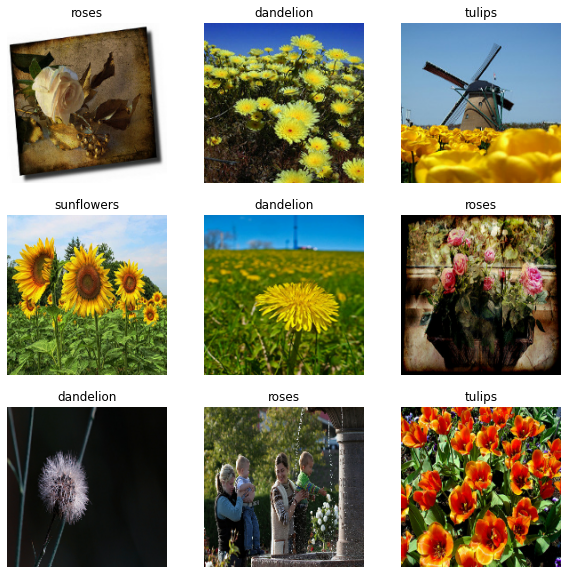

In [225]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Confiure the dataset for performance

`Dataset.cache()` keeps images in memory after they'r loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [226]:
#AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000)#.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache()#.prefetch(buffer_size=AUTOTUNE)

### Functional API(https://www.tensorflow.org/guide/keras/functional)

In [227]:

class GenericModel:
  def __init__(self, factor=1, input_shape=(180, 180, 3), label_dim=1000, n_layers_before_tf=0, cpu=False, hp=None, load_searched_arch=None, args=None):
    """[summary]
    Args:
        conversion_params (dict): containing the params for TF2UpStride & UpStride2TF conversion
        framework (str): [description]
        factor (int, optional): [description]. Defaults to 1.
        input_shape (tuple, optional): [description]. Defaults to (224, 224, 3).
        label_dim (int, optional): [description]. Defaults to 1000.
        n_layers_before_tf (int, optional): [description]. Defaults to 0.
        cpu (bool, optional): [description]. Defaults to False.
        hp ([type], optional): [description]. Defaults to None.
        load_searched_arch (str, optional): Yaml file that provide the model definition found by DNAS. Defaults to None.
    """
    self.hp = hp  # for keras tuner
    self._previous_layer = tf.keras.layers
    inputs = tf.keras.layers.Input(shape=input_shape)
    self.x = inputs
    self.model()
    x = self.x
    self.model = tf.keras.Model(inputs, x)


In [237]:
num_classes = 5

class MyModel(GenericModel):
    def model(self):
        self.x = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))(self.x)
        self.x = Conv2D(16, 3, padding='same')(self.x)
        self.x = Activation("relu")(self.x)        
        self.x = MaxPool2D(2)(self.x)
        self.x = Conv2D(32, 3, padding='same')(self.x)
        self.x = Activation("relu")(self.x)
        self.x = MaxPool2D(2)(self.x)
        self.x = Dropout(0.3)(self.x)
        self.x = Conv2D(64, 3, padding='same')(self.x)
        self.x = Activation("relu")(self.x)
        self.x = MaxPool2D(2)(self.x)
        self.x = Flatten()(self.x)
        self.x = Dense(128)(self.x)
        self.x = Dropout(0.3)(self.x)
        x = Dense(64)(self.x)
        y = Dense(32)(self.x)
        self.x = layers.concatenate([x,y])
        self.x = Activation("relu")(self.x)

        self.x = Dense(num_classes)(self.x)

In [238]:
model = MyModel()

In [239]:
model.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

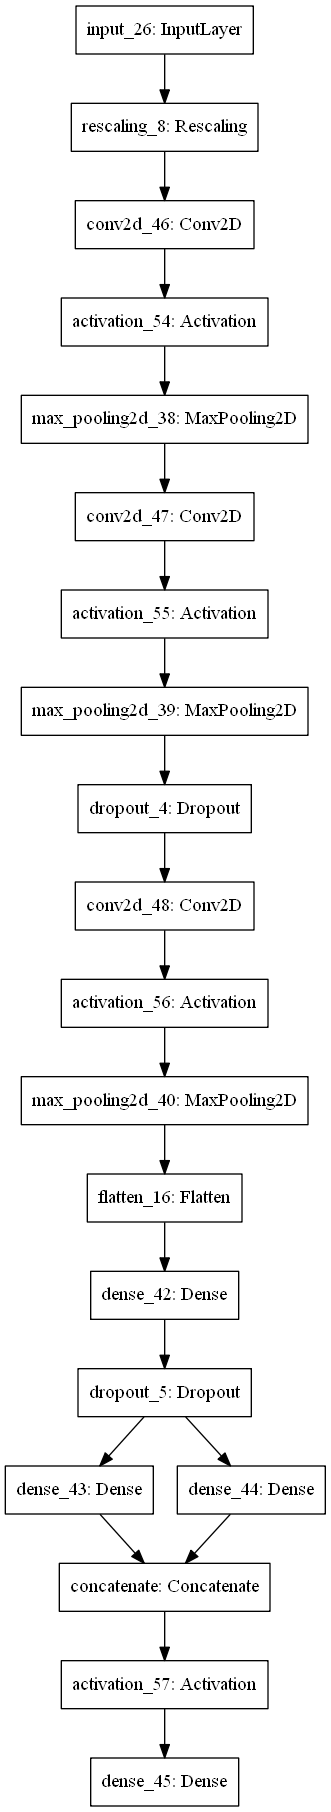

In [240]:
from keras.utils import plot_model
plot_model(model.model)

In [232]:
epochs=10
history = model.model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 24s 265ms/step - loss: 1.4140 - accuracy: 0.3828 - val_loss: 1.1895 - val_accuracy: 0.4659
Epoch 2/10
92/92 [==============================] - 23s 254ms/step - loss: 1.1334 - accuracy: 0.5375 - val_loss: 1.0750 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 24s 255ms/step - loss: 1.0201 - accuracy: 0.5964 - val_loss: 1.0051 - val_accuracy: 0.6076
Epoch 4/10
92/92 [==============================] - 23s 254ms/step - loss: 0.9234 - accuracy: 0.6485 - val_loss: 0.9368 - val_accuracy: 0.6403
Epoch 5/10
92/92 [==============================] - 24s 256ms/step - loss: 0.8118 - accuracy: 0.6918 - val_loss: 0.8912 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 24s 257ms/step - loss: 0.7200 - accuracy: 0.7289 - val_loss: 0.8874 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 24s 259ms/step - loss: 0.6182 - accuracy: 0.7674 - val_loss: 0.9039 - val_accuracy: 0.6594

In [243]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range